# Fetch data from Kaggle

In [11]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset", path='./data/raw')

# print("Path to dataset files:", path)

# Visualize data

In [25]:
import os 
from tqdm import tqdm
import numpy as np
import cv2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from matplotlib.image import imread
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout 
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping

In [13]:
# Define the directories
train_dir = "raw\\train"
test_dir = "raw\\test"

classes = os.listdir(train_dir)
classes


['glioma', 'meningioma', 'notumor', 'pituitary']

In [14]:
image_paths = []
image_labels = []

categories = os.listdir(train_dir)

for category in categories:
    category_path = os.path.join(train_dir, category)
    images = os.listdir(category_path)
    
    for image in images:
        image_path = os.path.join(category_path, image)
        image_paths.append(image_path)
        image_labels.append(category)

train_df = pd.DataFrame(data={'filepaths': image_paths, 'labels': image_labels})
train_df

,filepaths,labels
0,raw\train\glioma\Tr-glTr_0000.jpg,glioma
1,raw\train\glioma\Tr-glTr_0001.jpg,glioma
2,raw\train\glioma\Tr-glTr_0002.jpg,glioma
3,raw\train\glioma\Tr-glTr_0003.jpg,glioma
4,raw\train\glioma\Tr-glTr_0004.jpg,glioma
...,...,...
5707,raw\train\pituitary\Tr-pi_1452.jpg,pituitary
5708,raw\train\pituitary\Tr-pi_1453.jpg,pituitary
5709,raw\train\pituitary\Tr-pi_1454.jpg,pituitary
5710,raw\train\pituitary\Tr-pi_1455.jpg,pituitary


In [15]:
image_paths = []
image_labels = []

categories = os.listdir(test_dir)

for category in categories:
    category_path = os.path.join(test_dir, category)
    images = os.listdir(category_path)
    
    for image in images:
        image_path = os.path.join(category_path, image)
        image_paths.append(image_path)
        image_labels.append(category)

test_df = pd.DataFrame(data={'filepaths': image_paths, 'labels': image_labels})
test_df

,filepaths,labels
0,raw\test\glioma\Te-glTr_0000.jpg,glioma
1,raw\test\glioma\Te-glTr_0001.jpg,glioma
2,raw\test\glioma\Te-glTr_0002.jpg,glioma
3,raw\test\glioma\Te-glTr_0003.jpg,glioma
4,raw\test\glioma\Te-glTr_0004.jpg,glioma
...,...,...
1306,raw\test\pituitary\Te-pi_0295.jpg,pituitary
1307,raw\test\pituitary\Te-pi_0296.jpg,pituitary
1308,raw\test\pituitary\Te-pi_0297.jpg,pituitary
1309,raw\test\pituitary\Te-pi_0298.jpg,pituitary


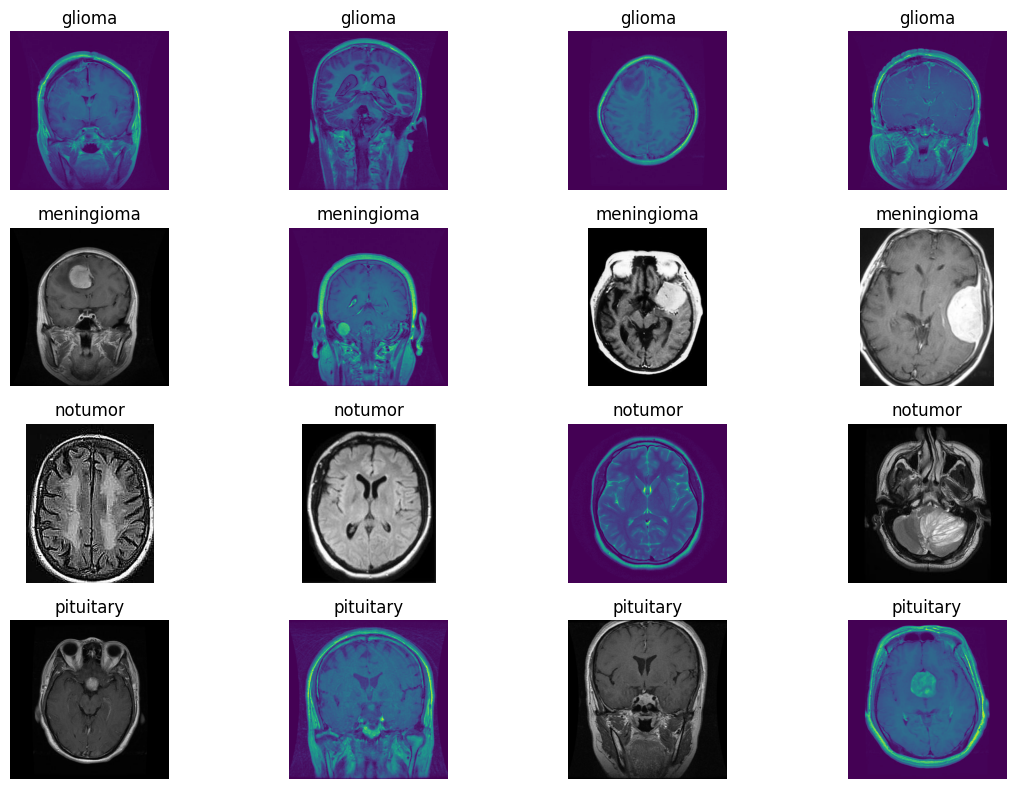

In [16]:
def plot_class_samples(df, classes, num_samples=4):
    plt.figure(figsize=(12,8))
    
    for i, cls in enumerate(classes):
        class_images = df[df['labels'] == cls]['filepaths'].sample(num_samples, random_state=42)
        
        for j, img_path in enumerate(class_images):
            img = Image.open(img_path)  # Load the image
            plt.subplot(len(classes), num_samples, i * num_samples + j + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(cls)
    
    plt.tight_layout()
    plt.show()
classes = train_df['labels'].unique()

plot_class_samples(train_df, classes)

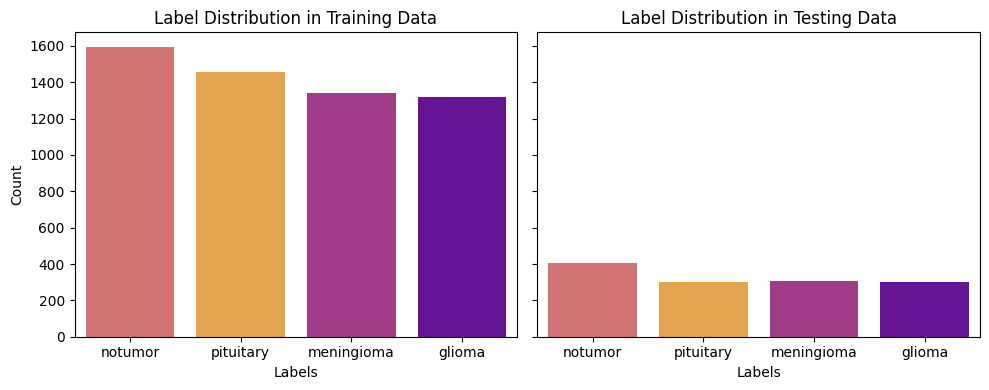

In [17]:
# Set up the figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# Plot for train_df
sns.countplot(
    data=train_df,
    x='labels',
    hue='labels',
    palette='plasma',
    order=train_df['labels'].value_counts().index,
    legend=False,
    ax=axes[0]
)
axes[0].set_title("Label Distribution in Training Data")
axes[0].set_xlabel("Labels")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x')

# Plot for test_df
sns.countplot(
    data=test_df,
    x='labels',
    hue='labels',
    palette='plasma',
    order=train_df['labels'].value_counts().index,  # Keep same order as train
    legend=False,
    ax=axes[1]
)
axes[1].set_title("Label Distribution in Testing Data")
axes[1].set_xlabel("Labels")
axes[1].tick_params(axis='x')

# Adjust layout for clarity
plt.tight_layout()
plt.show()

# Data preprocessing

In [18]:
def preprocess_brain_image(image_path, target_size=(512, 512)):
    # Read image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        raise ValueError(f"Failed to read image: {image_path}")

    # Get original dimensions
    h, w = image.shape[:2]

    # Check if the image is already square
    if h == w:
        resized_image = cv2.resize(image, target_size)
    else:
        # Calculate scaling factor to fit within target size
        scale = min(target_size[0] / h, target_size[1] / w)
        new_w, new_h = int(w * scale), int(h * scale)

        # Resize while maintaining aspect ratio
        resized_image = cv2.resize(image, (new_w, new_h))

        # Calculate padding (centered)
        pad_top = (target_size[1] - new_h) // 2
        pad_bottom = target_size[1] - new_h - pad_top
        pad_left = (target_size[0] - new_w) // 2
        pad_right = target_size[0] - new_w - pad_left

        # Pad the image with black (0)
        resized_image = cv2.copyMakeBorder(
            resized_image,
            pad_top, pad_bottom,
            pad_left, pad_right,
            cv2.BORDER_CONSTANT,
            value=(0, 0, 0)
        )

    # Convert to grayscale
    gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

    # Apply CLAHE for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=0.5, tileGridSize=(4, 4))
    enhanced = clahe.apply(gray)

    # Normalize to [0, 1] and convert back to uint8
    normalized = (enhanced / 255.0 * 255).astype(np.uint8)

    return resized_image, normalized

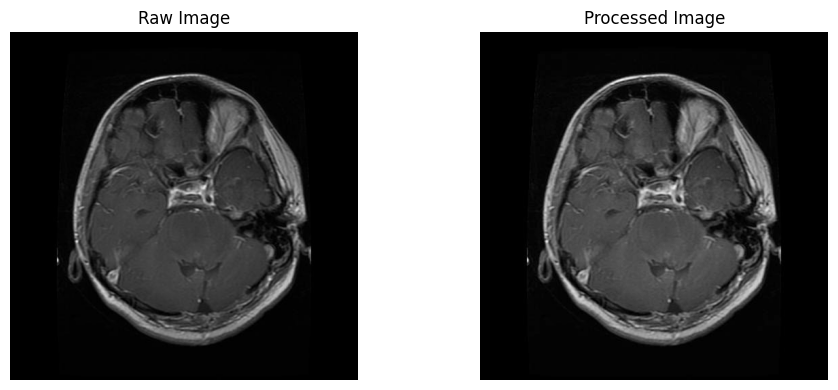

In [19]:
# Example usage
image_path = "raw/test/glioma/Te-gl_0010.jpg"  # Replace with your image path
raw_image, processed_image = preprocess_brain_image(image_path)

# Display raw and processed images side by side
plt.figure(figsize=(10, 4))

# Raw image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB))
plt.title("Raw Image")
plt.axis("off")

# Processed image
plt.subplot(1, 2, 2)
plt.imshow(processed_image, cmap="gray")
plt.title("Processed Image")
plt.axis("off")

plt.tight_layout()
plt.show()

# Save preprocessed images

In [26]:
def process_images_and_create_df(df, raw_base_dir="raw", processed_base_dir="processed"):
    processed_image_paths = []

    # Use tqdm for progress bar
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing Images"):
        raw_path = row['filepaths']
        processed_path = raw_path.replace(raw_base_dir, processed_base_dir)

        # Process the image first
        try:
            _, processed_image = preprocess_brain_image(raw_path)
            if processed_image is not None:
                # Create only the parent directory
                processed_dir = os.path.dirname(processed_path)
                os.makedirs(processed_dir, exist_ok=True)

                # Save the processed image
                cv2.imwrite(processed_path, processed_image)
                processed_image_paths.append(processed_path)
            else:
                print(f"Failed to process {raw_path}")
                processed_image_paths.append(None)
        except Exception as e:
            print(f"Error processing {raw_path}: {e}")
            processed_image_paths.append(None)

    # Create the new DataFrame with processed paths
    new_df = df.copy()
    new_df['processed_filepaths'] = processed_image_paths
    return new_df

In [27]:
# Example usage
test_processed_df = process_images_and_create_df(test_df)
train_processed_df = process_images_and_create_df(train_df)

Processing Images: 100%|██████████| 5712/5712 [00:45<00:00, 126.83it/s]


In [28]:
# Combine the DataFrames
combined_df = pd.concat([train_processed_df, test_processed_df], ignore_index=True)

# Save to CSV file
output_csv_path = "data.csv"
combined_df.to_csv(output_csv_path, index=False)

print(f"Combined DataFrame saved to: {output_csv_path}")

Combined DataFrame saved to: data.csv


## Comparison

In [29]:
# Function to display comparisons for each subdirectory
def display_image_comparison(df, base_dir='train', samples_per_class=2):
    # Filter train data
    train_df = df[df['filepaths'].str.contains(f'{base_dir}')]

    # Get unique subdirectories (labels)
    unique_labels = train_df['labels'].unique()

    # Collect images for plotting
    image_pairs = []

    # Iterate through each subdirectory (label)
    for label in unique_labels:
        # Filter for the current subdirectory
        label_df = train_df[train_df['labels'] == label]

        # Randomly select samples per class
        sample_df = label_df.sample(n=min(samples_per_class, len(label_df)), random_state=42)

        # Store image pairs for plotting
        for _, row in sample_df.iterrows():
            raw_path = row['filepaths']
            processed_path = row['processed_filepaths']

            # Read both raw and processed images
            raw_image = cv2.imread(raw_path)
            processed_image = cv2.imread(processed_path)

            if raw_image is not None and processed_image is not None:
                # Convert BGR to RGB for matplotlib
                raw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)
                processed_image = cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB)

                # Append as a tuple for later plotting
                image_pairs.append((label, raw_image, processed_image))

    # Plotting images in rows with 4 images per row (2 pairs)
    num_pairs = len(image_pairs)
    cols = 4  # 2 pairs per row (4 images)
    rows = (num_pairs * 2 + cols - 1) // cols  # Calculate needed rows

    plt.figure(figsize=(20, rows * 4))

    for idx, (label, raw_img, processed_img) in enumerate(image_pairs):
        # Raw image
        plt.subplot(rows, cols, 2 * idx + 1)
        plt.imshow(raw_img)
        plt.title(f"Raw - {label}")
        plt.axis("off")

        # Processed image
        plt.subplot(rows, cols, 2 * idx + 2)
        plt.imshow(processed_img)
        plt.title(f"Processed - {label}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

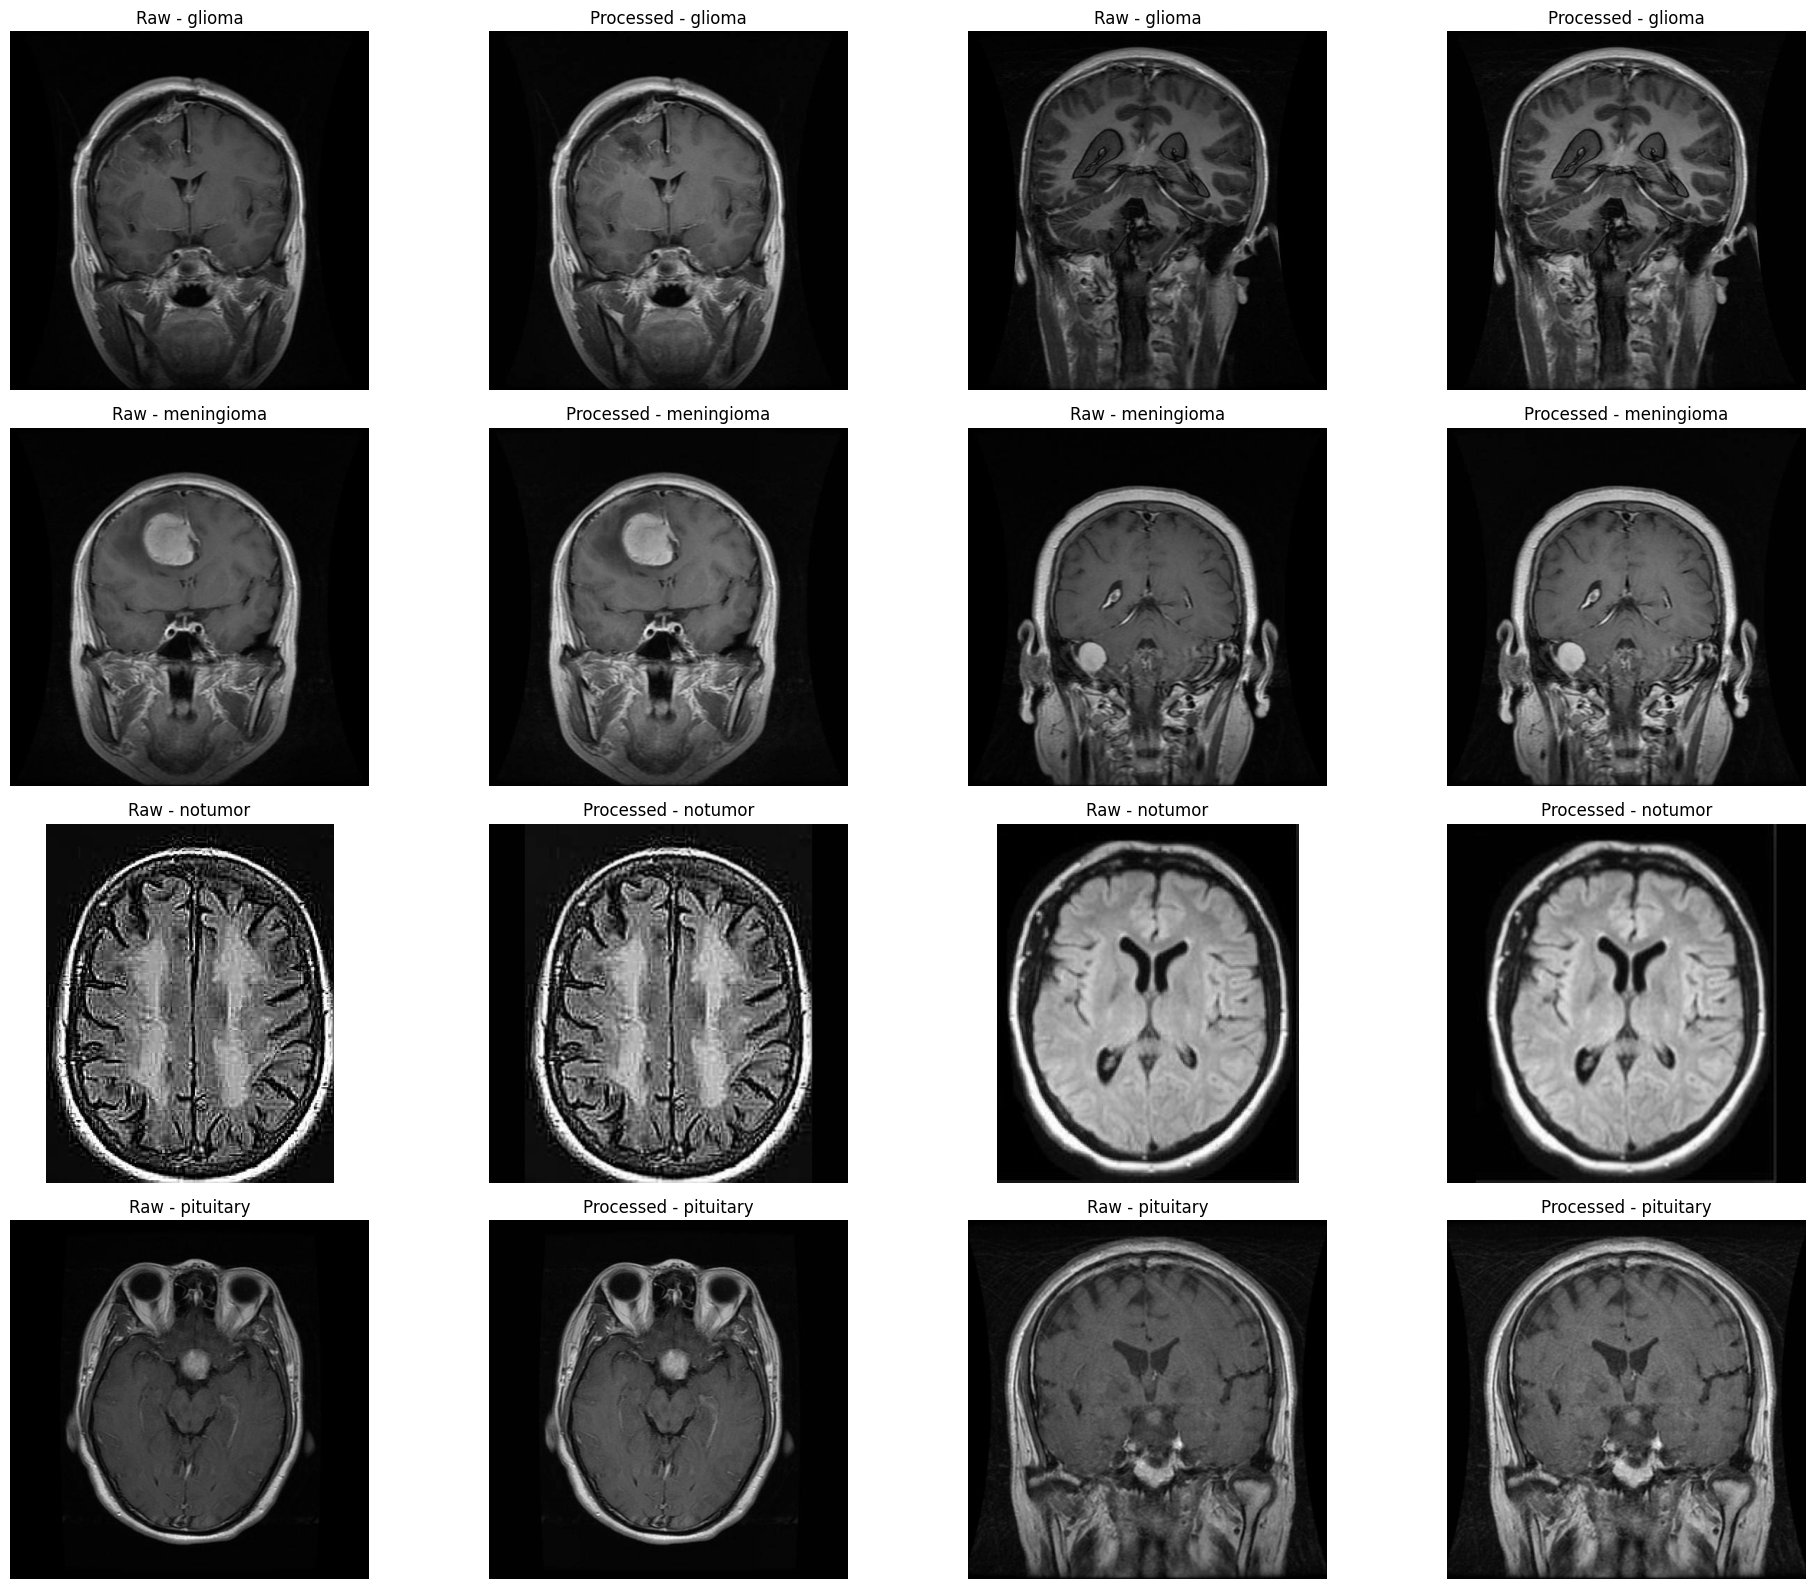

In [24]:
# Load the combined CSV file
combined_df = pd.read_csv("data.csv")

# Display 2 comparisons per subdirectory in the train set
display_image_comparison(combined_df, base_dir='train', samples_per_class=2)